In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir_rain='/thorncroftlab_rit/ahenny/rain/tccip_daily/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'

#This script plots composites of EP days associated with preceding northbound TCs

In [ ]:
ds=xr.open_dataset(dir+'ls_extreme_rain_taiwan_99_80.nc')
p=ds['large_scale_extreme_rain_all']#total rainfall on ER days
dates=ds.time
print(p)
mean_obs_list=p.mean(dim=('lat','lon'),skipna=True).values.tolist()
print(mean_obs_list)
dates_pd=pd.DatetimeIndex(dates.values)
years=[x.year for x in dates_pd]
print(years)

ds4=xr.open_dataset(dir+'taiwan_ep_days_stats_var95_newar.nc')
ar_yesno4=ds4['ar_yesno'].values.tolist()
ivt_yesno4=ds4['ivt_yesno'].values.tolist()
tc_yesno4=ds4['tc_yesno'].values.tolist()
other_yesno4=ds4['other_yesno'].values.tolist()
tc_linked_ar_yesno4=ds4['tc_linked_ar_yesno'].values.tolist()
tc_linked_ivt_yesno4=ds4['tc_linked_ivt_yesno'].values.tolist()
tc_remnant_linked_ivt_yesno4=ds4['ivt_tc_remnants_yesno'].values.tolist()
tc_remnant_ar_combo_yesno4=ds4['ar_tc_remnant_combo_yesno'].values.tolist()
tc_remnant_linked_ar_yesno4=ds4['tc_remnant_linked_ar_yesno'].values.tolist()
tc_remnants_yesno4=ds4['tc_remnants_yesno'].values.tolist()
tc_ar_combo_yesno4=ds4['tc_ar_combo_yesno'].values.tolist()

zipped_t1=list(zip(dates,ar_yesno4))#ar-related = green
zipped_t2=list(zip(dates,tc_linked_ar_yesno4))
zipped_t3=list(zip(dates,tc_remnant_linked_ar_yesno4))
zipped_t4=list(zip(dates,tc_yesno4))#tc-related = blue
zipped_t5=list(zip(dates,tc_ar_combo_yesno4))
zipped_t6=list(zip(dates,tc_remnant_ar_combo_yesno4))
zipped_t7=list(zip(dates,tc_remnants_yesno4))
zipped_t8=list(zip(dates,ivt_yesno4))#other IVT-related = grey
zipped_t9=list(zip(dates,tc_linked_ivt_yesno4))
zipped_t10=list(zip(dates,tc_remnant_linked_ivt_yesno4))
zipped_t11=list(zip(dates,other_yesno4))#unspecified = brown

dates_t1=[x[0].values for x in zipped_t1 if x[1]==1]
dates_t2=[x[0].values for x in zipped_t2 if x[1]==1]
dates_t3=[x[0].values for x in zipped_t3 if x[1]==1]
dates_t4=[x[0].values for x in zipped_t4 if x[1]==1]
dates_t5=[x[0].values for x in zipped_t5 if x[1]==1]
dates_t6=[x[0].values for x in zipped_t6 if x[1]==1]
dates_t7=[x[0].values for x in zipped_t7 if x[1]==1]
dates_t8=[x[0].values for x in zipped_t8 if x[1]==1]
dates_t9=[x[0].values for x in zipped_t9 if x[1]==1]
dates_t10=[x[0].values for x in zipped_t10 if x[1]==1]
dates_t11=[x[0].values for x in zipped_t11 if x[1]==1]

dates_ar=dates_t1+dates_t2+dates_t3
dates_tc=dates_t4+dates_t5+dates_t6+dates_t7
dates_other=dates_t8+dates_t9+dates_t10+dates_t11

dates_ar=pd.DatetimeIndex(dates_ar).sort_values()
dates_tc=pd.DatetimeIndex(dates_tc).sort_values()
dates_other=pd.DatetimeIndex(dates_other).sort_values()
print(len(dates_ar))

In [ ]:
ds6=xr.open_dataset(dir+'IBTrACS.WP.v04r00.nc')
print(ds6.lat.description)
wind_tc=ds6.usa_wind
lat_tc=ds6.lat
lon_tc=ds6.lon
#nature_tc=ds6.nature
ds7=xr.open_dataset(dir+'ibtracs_wp_time.nc')
years_tc=ds7.years
months_tc=ds7.months
days_tc=ds7.days
hours_tc=ds7.hours
nature_tc=ds7.nature#1 if tropical, 0 if not
lat_tc['storm']=years_tc['storm']
lon_tc['storm']=years_tc['storm']
wind_tc['storm']=years_tc['storm']
print(lat_tc.storm)
print(months_tc.min().values)
print(years_tc.storm)

In [ ]:
lat_min_2=20
lat_max_2=25
lon_min_2=122
lon_max_2=142

storms_select=[]
dates_list_zone=[]
for i in range(lat_tc.storm.size):
    print(i)
    count_storm=0
    lats_list=lat_tc[i,:].values.tolist()
    lons_list=lon_tc[i,:].values.tolist()
    years_list=years_tc[i,:].values.tolist()
    months_list=months_tc[i,:].values.tolist()
    days_list=days_tc[i,:].values.tolist()
    hours_list=hours_tc[i,:].values.tolist()
    winds_list=wind_tc[i,:].values.tolist()
    for j in range(1,len(lats_list)):
        lat=lats_list[j]
        lon=lons_list[j]
        lat_prev=lats_list[j-1]
        lon_prev=lons_list[j-1]
        year=years_list[j]
        month=months_list[j]
        day=days_list[j]
        hour=hours_list[j]
        wind=winds_list[j]
        if lat_min_2<=lat<=lat_max_2 and lon_min_2<=lon<=lon_max_2:
            if lat-lat_prev>=0 and lon-lon_prev>=0 and count_storm==0:
                if month==6 or month==5 and day>=15:
                    if 1979<=year<=2019:# and wind>=64:
                        storms_select.append(i)
                        count_storm=1
                        
                        dates_list_zone.append(dt.datetime(int(year),int(month),int(day),int(hour)))
                        
        elif lat_min_2<=lat_prev<=lat_max_2 and lon_min_2<=lon_prev<=lon_max_2:
            if lat-lat_prev>=0 and lon-lon_prev>=0 and count_storm==0:
                if month==6 or month==5 and day>=15:
                    if 1979<=year<=2019:# and wind>=64:
                        storms_select.append(i)
                        dates_list_zone.append(dt.datetime(int(year),int(month),int(day),int(hour)))
                        count_storm=1

print(dates_list_zone)
dates_list_zone=list(set(dates_list_zone))
print(dates_list_zone)

dates_days=[]
for i in range(len(dates_list_zone)):
    date_select=dates_list_zone[i]
    year=date_select.year
    month=date_select.month
    day=date_select.day
    
    if date_select.hour>=18:
        date_choose=dt.datetime(year,month,day,6)+dt.timedelta(days=1)
    else:
        date_choose=dt.datetime(year,month,day,6)
    dates_days.append(date_choose)

dates_days=list(set(dates_days))
print(dates_days)

print(storms_select)
print(len(storms_select))

In [5]:
dates_days=pd.DatetimeIndex(dates_days).sort_values()

In [ ]:
#Here take only first day of each event

dates_ar_northward=[]
for i in range(len(dates_ar)):
    print(i)
    for j in range(len(dates_days)):
        if 4<=(dates_ar[i]-dates_days[j]).days<=10:
            dates_ar_northward.append(dates_ar[i])
            
dates_ar_northward=pd.DatetimeIndex(dates_ar_northward).unique()
dates_ar_non=[x for x in dates_ar if x not in dates_ar_northward]

print(dates_ar_northward)
print(dates_ar_non)
print(len(dates_ar_northward))
print(len(dates_ar_non))

dates_ar_northward_new=[]
dates_ar_non_new=[]
for i in range(1,len(dates_ar_northward)):
    if (dates_ar_northward[i]-dates_ar_northward[i-1]).days==1:
        pass
    else:
        dates_ar_northward_new.append(dates_ar_northward[i])
        
for i in range(1,len(dates_ar_non)):
    if (dates_ar_non[i]-dates_ar_non[i-1]).days==1:
        pass
    else:
        dates_ar_non_new.append(dates_ar_non[i])
        
print('MODIFIED')
print(dates_ar_northward_new)
print(dates_ar_non_new)
print(len(dates_ar_northward_new))
print(len(dates_ar_non_new))

In [ ]:
df=xr.open_dataset(dir+'era_5_mys_mslp_taiwan.nc')
slp=df.msl
print(slp)
df1=xr.open_dataset(dir+'era_5_mys_u_850_taiwan.nc')
u_850=df1['u']
df2=xr.open_dataset(dir+'era_5_mys_v_850_taiwan.nc')
v_850=df2['v']
df3=xr.open_dataset(dir+'era_5_mys_ivtx_taiwan.nc')
ivtx=df3['p71.162']
df4=xr.open_dataset(dir+'era_5_mys_ivty_taiwan.nc')
ivty=df4['p72.162']

In [8]:
#Retrieve login credintial for RDA.
import requests
from pathlib import Path
HOME = str(Path.home())
credFile = open(HOME+'/.rdarc','r')
userId, pw = credFile.read().split()
session = requests.Session()
session.auth = (userId, pw)

0
1987-06-25 06:00:00
1987-06-25 06:00:00
1987-06-16 06:00:00
1
1997-06-04 06:00:00
1997-06-04 06:00:00
1997-05-26 06:00:00
(16.299999237060547, 120.78572082519531)
(9.699999809265137, 160.8000030517578)
2
2003-06-07 06:00:00
2003-06-07 06:00:00
2003-05-29 06:00:00
(22.375, 126.97500610351562)
3
2005-06-12 06:00:00
2005-06-12 06:00:00
2005-06-03 06:00:00
(12.975000381469727, 133.6750030517578)
4
2012-06-10 06:00:00
2012-06-10 06:00:00
2012-06-01 06:00:00
(14.899998664855957, 125.50667572021484)
5
2015-05-24 06:00:00
2015-05-24 06:00:00
2015-05-15 06:00:00
(13.600000381469727, 145.625)
(48.30000305175781, 171.60000610351562)


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


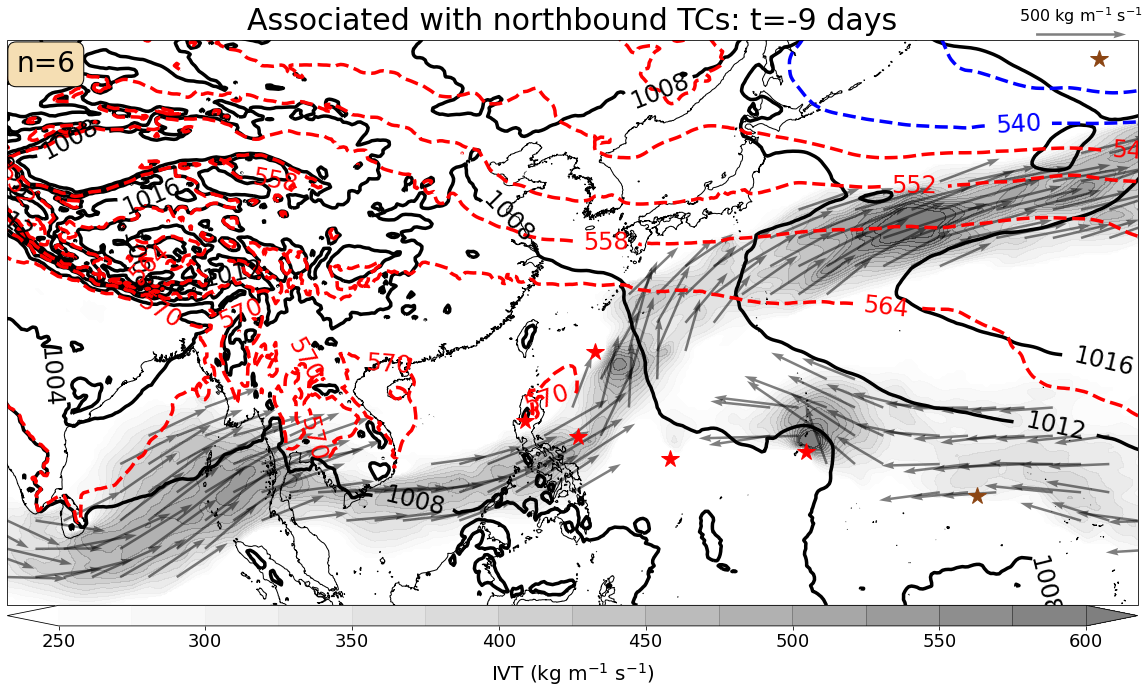

In [14]:
#take composites

import matplotlib as mpl
lon_range=np.arange(70,180,0.25)
lat_range=np.arange(0,60,0.25)

#offsets=[x*24 for x in range(-10,11)]#(-10,11)
offsets=[-9*24]
for l in range(len(offsets)):
    offset=offsets[l]
    mapcrs = ccrs.PlateCarree(central_longitude=125)
    fig = plt.figure(1, figsize=(16, 12))
    ax = plt.subplot(111, projection=mapcrs)
    #offset=24*0#in hours
    for i in range(len(dates_ar_northward_new)):
        print(i)
        date=dates_ar_northward_new[i]
        print(date)
        hour=date.hour
        month=date.month
        day=date.day
        if hour in [3,9,15]:#check that time is 6-hourly; round up
            hour=hour+3
        if hour==21:
            hour=0
            if date.month==6 and date.day==30:
                month=7
                day=1
            if date.month==5 and date.day==31:
                month=6
                day=1
            else:
                day=date.day+1
        date=dt.datetime(date.year,month,day,hour)
        print(date)
        date=date+dt.timedelta(hours=offset)
        print(date)

        year=date.year
        month=date.month
        day=date.day
        hour=date.hour

        date_range=[dt.datetime(year,5,1,0)+dt.timedelta(hours=6.*x) for x in np.arange(61*4)]
        if date in date_range:
            #use pre-existing datasets
            slp_select=slp.sel(time=date,latitude=lat_range,longitude=lon_range)
            u_850_select=u_850.sel(time=date,latitude=lat_range,longitude=lon_range)
            v_850_select=v_850.sel(time=date,latitude=lat_range,longitude=lon_range)
            ivtx_select=ivtx.sel(time=date,latitude=lat_range,longitude=lon_range)
            ivty_select=ivty.sel(time=date,latitude=lat_range,longitude=lon_range)
            ivt_mag_select=np.sqrt(ivtx_select**2+ivty_select**2)

            if month<10:
                month_str='0'+str(month)
            else:
                month_str=str(month)

            if day<10:
                day_str='0'+str(day)
            else:
                day_str=str(day)
            urlz='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'+str(year)+month_str+'/e5.oper.an.pl.128_129_z.ll025sc.'+str(year)+month_str+day_str+'00_'+str(year)+month_str+day_str+'23.nc'
            store_z = xr.backends.PydapDataStore.open(urlz, session=session)
            ds_z=xr.open_dataset(store_z)
            z=ds_z.Z.sel(latitude=lat_range,longitude=lon_range)
            thickness_select=z.sel(time=date,level=500)-z.sel(time=date,level=1000)

        else:
            #load by TDS

            if month<10:
                month_str='0'+str(month)
            else:
                month_str=str(month)

            if day<10:
                day_str='0'+str(day)
            else:
                day_str=str(day)

            if month==5:
                month_length_str='31'
            if month==6:
                month_length_str='30'
            if month==7:
                month_length_str='31'

            urlu='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'+str(year)+month_str+'/e5.oper.an.pl.128_131_u.ll025uv.'+str(year)+month_str+day_str+'00_'+str(year)+month_str+day_str+'23.nc'
            urlv='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'+str(year)+month_str+'/e5.oper.an.pl.128_132_v.ll025uv.'+str(year)+month_str+day_str+'00_'+str(year)+month_str+day_str+'23.nc'
            urlz='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'+str(year)+month_str+'/e5.oper.an.pl.128_129_z.ll025sc.'+str(year)+month_str+day_str+'00_'+str(year)+month_str+day_str+'23.nc'
            urlt='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'+str(year)+month_str+'/e5.oper.an.pl.128_130_t.ll025sc.'+str(year)+month_str+day_str+'00_'+str(year)+month_str+day_str+'23.nc'

            urlivty='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.vinteg/'+str(year)+month_str+'/e5.oper.an.vinteg.162_072_viwvn.ll025sc.'+str(year)+month_str+'0100_'+str(year)+month_str+month_length_str+'23.nc'
            urlivtx='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.vinteg/'+str(year)+month_str+'/e5.oper.an.vinteg.162_071_viwve.ll025sc.'+str(year)+month_str+'0100_'+str(year)+month_str+month_length_str+'23.nc'
            urlslp='https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/'+str(year)+month_str+'/e5.oper.an.sfc.128_151_msl.ll025sc.'+str(year)+month_str+'0100_'+str(year)+month_str+month_length_str+'23.nc'

            store_u = xr.backends.PydapDataStore.open(urlu, session=session)
            store_v = xr.backends.PydapDataStore.open(urlv, session=session)
            store_z = xr.backends.PydapDataStore.open(urlz, session=session)
            store_t = xr.backends.PydapDataStore.open(urlt, session=session)

            store_ivtx = xr.backends.PydapDataStore.open(urlivtx, session=session)
            store_ivty = xr.backends.PydapDataStore.open(urlivty, session=session)
            store_slp = xr.backends.PydapDataStore.open(urlslp, session=session)

            ds_u=xr.open_dataset(store_u)
            ds_v=xr.open_dataset(store_v)
            ds_z=xr.open_dataset(store_z)
            ds_t=xr.open_dataset(store_t)

            ds_ivtx=xr.open_dataset(store_ivtx)
            ds_ivty=xr.open_dataset(store_ivty)
            ds_slp=xr.open_dataset(store_slp)

            #print(ds_ivtx)

            u=ds_u.U.sel(latitude=lat_range,longitude=lon_range)
            v=ds_v.V.sel(latitude=lat_range,longitude=lon_range)
            z=ds_z.Z.sel(latitude=lat_range,longitude=lon_range)
            t=ds_t.T.sel(latitude=lat_range,longitude=lon_range)

            ivtx_tds=ds_ivtx.VIWVE.sel(latitude=lat_range,longitude=lon_range)
            ivty_tds=ds_ivty.VIWVN.sel(latitude=lat_range,longitude=lon_range)
            slp_tds=ds_slp.MSL.sel(latitude=lat_range,longitude=lon_range)

            u_850_select=u.sel(time=date,level=850)
            v_850_select=v.sel(time=date,level=850)
            thickness_select=z.sel(time=date,level=500)-z.sel(time=date,level=1000)

            ivtx_select=ivtx_tds.sel(time=date,latitude=lat_range,longitude=lon_range)
            ivty_select=ivty_tds.sel(time=date,latitude=lat_range,longitude=lon_range)
            ivt_mag_select=np.sqrt(ivtx_select**2+ivty_select**2)
            slp_select=slp_tds.sel(time=date,latitude=lat_range,longitude=lon_range)

        if i==0:
            u_850_concat=u_850_select
            v_850_concat=v_850_select
            slp_concat=slp_select
            ivtx_concat=ivtx_select
            ivty_concat=ivty_select
            ivt_mag_concat=ivt_mag_select
            thickness_concat=thickness_select
        else:
            u_850_concat=xr.concat([u_850_concat,u_850_select],dim='time')
            v_850_concat=xr.concat([v_850_concat,v_850_select],dim='time')
            slp_concat=xr.concat([slp_concat,slp_select],dim='time')
            ivtx_concat=xr.concat([ivtx_concat,ivtx_select],dim='time')
            ivty_concat=xr.concat([ivty_concat,ivty_select],dim='time')
            ivt_mag_concat=xr.concat([ivt_mag_concat,ivt_mag_select],dim='time')
            thickness_concat=xr.concat([thickness_concat,thickness_select],dim='time')

    
        check_lat_tc=lat_tc.where(years_tc==year,drop=True)
        check_lat_tc=check_lat_tc.where(months_tc==month,drop=True)
        check_lat_tc=check_lat_tc.where(days_tc==day,drop=True)
        check_lat_tc=check_lat_tc.where(hours_tc==hour,drop=True)
        #TS,SS,EX,ET,
        check_lat_tc_trop=check_lat_tc.where(nature_tc==1,drop=True)
        check_lat_tc_nontrop=check_lat_tc.where(nature_tc!=1,drop=True)
        
        check_lat_tc_trop_list=[]
        for i in range(check_lat_tc_trop.storm.size):
            check_lat_tc_trop_values=check_lat_tc_trop[i,:].values.tolist()
            check_lat_tc_trop_values=[x for x in check_lat_tc_trop_values if x>0]
            if len(check_lat_tc_trop_values)>0:
                check_lat_tc_trop_value=check_lat_tc_trop_values[0]
                check_lat_tc_trop_list.append(check_lat_tc_trop_value)
                
        check_lat_tc_nontrop_list=[]
        for i in range(check_lat_tc_nontrop.storm.size):
            check_lat_tc_nontrop_values=check_lat_tc_nontrop[i,:].values.tolist()
            check_lat_tc_nontrop_values=[x for x in check_lat_tc_nontrop_values if x>0]
            if len(check_lat_tc_nontrop_values)>0:
                check_lat_tc_nontrop_value=check_lat_tc_nontrop_values[0]
                check_lat_tc_nontrop_list.append(check_lat_tc_nontrop_value)
        
        check_lon_tc=lon_tc.where(years_tc==year,drop=True)
        check_lon_tc=check_lon_tc.where(months_tc==month,drop=True)
        check_lon_tc=check_lon_tc.where(days_tc==day,drop=True)
        check_lon_tc=check_lon_tc.where(hours_tc==hour,drop=True)
        check_lon_tc_trop=check_lon_tc.where(nature_tc==1,drop=True)
        check_lon_tc_nontrop=check_lon_tc.where(nature_tc!=1,drop=True)
        
        check_lon_tc_trop_list=[]
        for i in range(check_lon_tc_trop.storm.size):
            check_lon_tc_trop_values=check_lon_tc_trop[i,:].values.tolist()
            check_lon_tc_trop_values=[x for x in check_lon_tc_trop_values if x>-1000]
            if len(check_lon_tc_trop_values)>0:
                check_lon_tc_trop_value=check_lon_tc_trop_values[0]
                check_lon_tc_trop_list.append(check_lon_tc_trop_value)
                
        check_lon_tc_nontrop_list=[]
        for i in range(check_lon_tc_nontrop.storm.size):
            check_lon_tc_nontrop_values=check_lon_tc_nontrop[i,:].values.tolist()
            check_lon_tc_nontrop_values=[x for x in check_lon_tc_nontrop_values if x>-1000]
            if len(check_lon_tc_nontrop_values)>0:
                check_lon_tc_nontrop_value=check_lon_tc_nontrop_values[0]
                check_lon_tc_nontrop_list.append(check_lon_tc_nontrop_value)
        
        if len(check_lat_tc_trop_list)>0 and len(check_lon_tc_trop_list)>0:
            for i in range(len(check_lat_tc_trop_list)):
                lat_tc_single=check_lat_tc_trop_list[i]
                lon_tc_single=check_lon_tc_trop_list[i]
                print((lat_tc_single,lon_tc_single))
                if 0<=lat_tc_single<=50 and 85<=lon_tc_single<=175:
                    ax.plot(lon_tc_single,lat_tc_single,marker='*',color='r',transform=ccrs.PlateCarree(),markersize=18,zorder=41)
                
        if len(check_lat_tc_nontrop_list)>0 and len(check_lon_tc_nontrop_list)>0:
            for i in range(len(check_lat_tc_nontrop_list)):
                lat_tc_single=check_lat_tc_nontrop_list[i]
                lon_tc_single=check_lon_tc_nontrop_list[i]
                print((lat_tc_single,lon_tc_single))
                if 0<=lat_tc_single<=50 and 85<=lon_tc_single<=175:
                    ax.plot(lon_tc_single,lat_tc_single,marker='*',color='saddlebrown',transform=ccrs.PlateCarree(),markersize=18,zorder=41)
                
    slp_mean=slp_concat.mean(dim='time',skipna=True)
    u_850_mean=u_850_concat.mean(dim='time',skipna=True)
    v_850_mean=v_850_concat.mean(dim='time',skipna=True)
    ivtx_mean=ivtx_concat.mean(dim='time',skipna=True)
    ivty_mean=ivty_concat.mean(dim='time',skipna=True)
    ivt_mag_mean=ivt_mag_concat.mean(dim='time',skipna=True)

    ivt_mag_mean_calc=np.sqrt(ivtx_mean**2+ivty_mean**2)
    thickness_mean=thickness_concat.mean(dim='time',skipna=True)

    
    
    ax.set_extent([75, 175, 0, 50], ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
    ax.add_feature(countries)

    ivt_250=ivt_mag_mean_calc.where(ivt_mag_mean_calc>=250.)
    cax1=ax.contourf(ivt_250.longitude,ivt_250.latitude,ivt_250,levels=np.arange(250,625,25),extend='both',transform=ccrs.PlateCarree(),cmap=plt.cm.Greys,alpha=0.5)

    cbar = plt.colorbar(cax1, orientation='horizontal', pad=0, aspect=50,fraction=0.046)
    cbar.set_label('IVT (kg m$^{-1}$ s$^{-1}$)',fontsize=20,labelpad=10)
    cbar.ax.tick_params(labelsize=18)

    c=ax.contour(slp_select.longitude,slp_select.latitude,slp_mean/100.,linewidths=3.5,transform=ccrs.PlateCarree(),colors='k',levels=np.arange(960,1040,4))
    plt.clabel(c,fmt='%.00f',fontsize=24)

    c1=ax.contour(thickness_mean.longitude,thickness_mean.latitude,thickness_mean/100.,linewidths=3.5,linestyles='--',transform=ccrs.PlateCarree(),colors=['b','b','b','b','b','r','r','r','r','r','r'],levels=np.arange(516,580,6))
    plt.clabel(c1,fmt='%.00f',fontsize=24)

    ivt_mag_mean=np.sqrt(ivtx_mean**2+ivty_mean**2)
    ivtx_mean_sel=ivtx_mean.where(ivt_mag_mean>=300.)
    ivty_mean_sel=ivty_mean.where(ivt_mag_mean>=300.)
    X=10
    q=ax.quiver(ivtx_mean.longitude[0::X].values,ivtx_mean.latitude[0::X].values,ivtx_mean_sel[0::X,0::X].values,ivty_mean_sel[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=400,width=0.035,alpha=0.5)
    ax.quiverkey(q,0.95,1.01,500,'500 kg m$^{-1}$ s$^{-1}$',fontproperties={'size':16})

    #cax21=ax.contourf(ivtx.longitude,ivtx.latitude,ivt_250.where(ar_select==1),levels=np.arange(250,1040,50),extend='both',transform=ccrs.PlateCarree(),cmap=plt.cm.Greys,alpha=0.5,label='Identified AR')
    #cax2=ax.contourf(ar_select.longitude,ar_select.latitude,ar_select,[0,1],colors='b',transform=ccrs.PlateCarree(),hatches=[None,'.'],alpha=0.1,label='Identified AR',zorder=20)

    mpl.rcParams['hatch.linewidth']=0.01
    vtime=date
    #plt.title('ERA5 850-hPa winds (m/s), MSLP (hPa), thickness (dm), and IVT (kg m$^{-1}$ s$^{-1}$)',loc='left',fontsize=16)
    #plt.title('Valid Time: {}'.format(vtime), loc='right',fontsize=16)
    plt.title('Associated with northbound TCs: t='+str(int(offset/24))+' days',fontsize=30,pad=10)
    #ax.text(96.5,53,'Associated with northbound TCs: t='+str(int(offset/24))+' days',transform=ccrs.PlateCarree(),fontsize=30)#103
    #ax.text(93.5,53,'Not associated with northbound TCs: t='+str(int(offset/24))+' days',transform=ccrs.PlateCarree(),fontsize=30)#103
    #96.5

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
    ax.text(0.008, 0.982,'n='+str(u_850_concat.time.size), transform=ax.transAxes, fontsize=28,verticalalignment='top', bbox=props,zorder=30)
    plt.tight_layout()
    plt.show()

    #fig.savefig(dir+'taiwan_northbound_tc_ar_dominant_composites_'+str(l)+'.png')
    #fig.savefig(dir+'taiwan_non_tc_ar_dominant_composites_'+str(l)+'.png')
    plt.close()

In [13]:
fig.savefig(dir+'taiwan_paper_nb_tc_comparison_1.png')

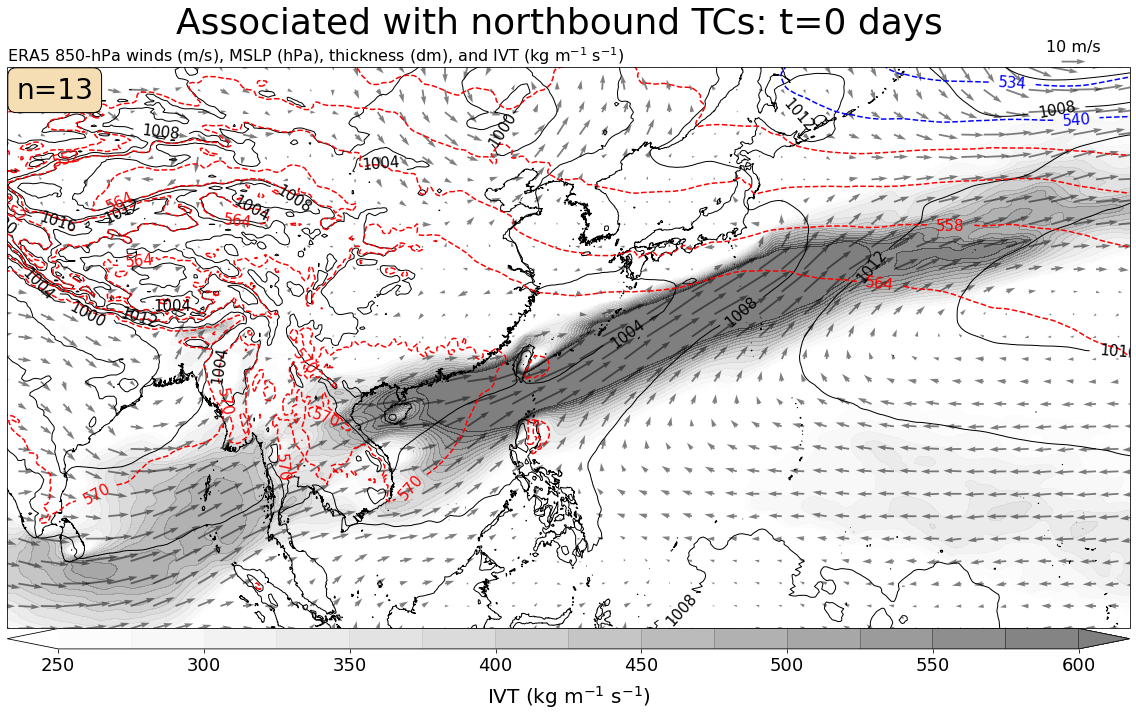

In [119]:
import matplotlib as mpl

slp_mean=slp_concat.mean(dim='time',skipna=True)
u_850_mean=u_850_concat.mean(dim='time',skipna=True)
v_850_mean=v_850_concat.mean(dim='time',skipna=True)
ivtx_mean=ivtx_concat.mean(dim='time',skipna=True)
ivty_mean=ivty_concat.mean(dim='time',skipna=True)
ivt_mag_mean=ivt_mag_concat.mean(dim='time',skipna=True)

ivt_mag_mean_calc=np.sqrt(ivtx_mean**2+ivty_mean**2)
thickness_mean=thickness_concat.mean(dim='time',skipna=True)

mapcrs = ccrs.PlateCarree(central_longitude=125)
fig = plt.figure(1, figsize=(16, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([75, 175, 0, 50], ccrs.PlateCarree())
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)

ivt_250=ivt_mag_mean_calc.where(ivt_mag_mean_calc>=250.)
cax1=ax.contourf(ivt_250.longitude,ivt_250.latitude,ivt_250,levels=np.arange(250,625,25),extend='both',transform=ccrs.PlateCarree(),cmap=plt.cm.Greys,alpha=0.5)
            
cbar = plt.colorbar(cax1, orientation='horizontal', pad=0, aspect=50,fraction=0.046)
cbar.set_label('IVT (kg m$^{-1}$ s$^{-1}$)',fontsize=20,labelpad=10)
cbar.ax.tick_params(labelsize=18)

c=ax.contour(slp_select.longitude,slp_select.latitude,slp_mean/100.,linewidths=1.0,transform=ccrs.PlateCarree(),colors='k',levels=np.arange(960,1040,4))
plt.clabel(c,fmt='%.00f',fontsize=15)

c1=ax.contour(thickness_mean.longitude,thickness_mean.latitude,thickness_mean/100.,linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),colors=['b','b','b','b','b','r','r','r','r','r','r'],levels=np.arange(516,580,6))
plt.clabel(c1,fmt='%.00f',fontsize=15)

X=8
q=ax.quiver(u_850_select.longitude[0::X].values,u_850_select.latitude[0::X].values,u_850_mean[0::X,0::X].values,v_850_mean[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=30,width=0.025,alpha=0.5)
ax.quiverkey(q,0.95,1.01,10,'10 m/s',fontproperties={'size':16})

#cax21=ax.contourf(ivtx.longitude,ivtx.latitude,ivt_250.where(ar_select==1),levels=np.arange(250,1040,50),extend='both',transform=ccrs.PlateCarree(),cmap=plt.cm.Greys,alpha=0.5,label='Identified AR')
#cax2=ax.contourf(ar_select.longitude,ar_select.latitude,ar_select,[0,1],colors='b',transform=ccrs.PlateCarree(),hatches=[None,'.'],alpha=0.1,label='Identified AR',zorder=20)

mpl.rcParams['hatch.linewidth']=0.01
vtime=date
plt.title('ERA5 850-hPa winds (m/s), MSLP (hPa), thickness (dm), and IVT (kg m$^{-1}$ s$^{-1}$)',loc='left',fontsize=16)
#plt.title('Valid Time: {}'.format(vtime), loc='right',fontsize=16)
ax.text(90,53,'Associated with northbound TCs: t=0 days',transform=ccrs.PlateCarree(),fontsize=36)#103
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
ax.text(0.008, 0.984,'n='+str(u_850_concat.time.size), transform=ax.transAxes, fontsize=28,verticalalignment='top', bbox=props,zorder=30)
plt.tight_layout()
plt.show()